# Searching Higgs boson with deep neural network

This work aims to replicate work presented in paper *Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).* Nevertheless, the original paper uses Pylearn2 to train neural networks, but Tensorflow and Keras are used in this work. 

The dataset can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS). Data set description can be found from the article. See also [code in GitHub](https://github.com/uci-igb/higgs-susy) used in the original work. 

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

Load the dataset. We need only the class label and low level features, that is, columns 1-22. High level features which have been derived from low level features, are in columns 23-29 and are left out. 

In [2]:
nrows = 500000
dataset = pd.read_csv('HIGGS.csv.gz', 
                      compression='gzip', 
                      usecols = list(range(0,22)), 
                      nrows = nrows,
                      header = None)

Print the firs few roads to make sure loading was done correctly. 

In [3]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


Rename columns to be more descriptive. More details can be found from the original article.

In [4]:
dataset.columns = ['class label', 'lepton pT', 'lepton eta', 'lepton phi', 
                   'missing energy magnitude', 'missing energy phi',
                   'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
                   'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                   'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 
                   'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag']

Print summary of the dataset. 

In [5]:
dataset.describe()

,class label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.529406,0.992273,-0.000556,-0.000553,0.997768,-0.001639,0.990045,-0.001745,0.000703,1.001603,...,-0.000085,0.999973,0.992619,0.001635,0.000058,1.001139,0.985844,-0.000402,-0.002381,0.997535
std,0.499135,0.564812,1.007581,1.005965,0.599486,1.006992,0.474977,1.009909,1.006259,1.028063,...,1.007269,1.049071,0.487352,1.008450,1.005301,1.194513,0.504664,1.008514,1.005571,1.399199
min,0.000000,0.274697,-2.434976,-1.742508,0.000626,-1.743944,0.138602,-2.969725,-1.741237,0.000000,...,-1.742372,0.000000,0.263608,-2.729663,-1.742069,0.000000,0.365354,-2.497265,-1.742691,0.000000
25%,0.000000,0.591302,-0.737349,-0.871931,0.576872,-0.873559,0.678626,-0.688235,-0.866988,0.000000,...,-0.871844,0.000000,0.651555,-0.697988,-0.869470,0.000000,0.617767,-0.715023,-0.873144,0.000000
50%,1.000000,0.854469,-0.002002,0.000971,0.890737,-0.002751,0.894270,-0.002996,0.000058,1.086538,...,-0.000203,0.000000,0.897601,0.001083,-0.002416,0.000000,0.868477,-0.001294,-0.005259,0.000000
75%,1.000000,1.238057,0.738214,0.870439,1.291460,0.872038,1.169549,0.685214,0.869421,2.173076,...,0.872647,2.214872,1.222149,0.701975,0.871395,2.548224,1.221660,0.714934,0.867721,3.101961
max,1.000000,8.711782,2.434868,1.743236,9.900929,1.743251,8.382610,2.969674,1.741454,2.173076,...,1.743175,2.214872,8.509908,2.730009,1.742884,2.548224,11.295308,2.498009,1.743372,3.101961


Split dataset into input (X) and output (y) variables. Trivially, class label is the output variable.

In [6]:
X = dataset.iloc[:,1:23]
y = dataset.iloc[:,0] 
X.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


Define constants for neural network architecture. 

In [7]:
noInputUnits = X.shape[1]
noHiddenUnits = 100
learningRate = 0.05
learningRateDecay = 1.0000002
learningRateMin = 1e-6
weightDecay = 1e-5
batchSize = 100
noEpochs = 20
validationSplit = 0.3
#TODO TODO#
#weight initialization 

Define the neural network. 

In [8]:
model = Sequential()
model.add(Dense(noHiddenUnits, input_dim=noInputUnits, activation='tanh'))
model.add(Dense(noHiddenUnits, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,401
Trainable params: 12,401
Non-trainable params: 0
_________________________________________________________________


Compile the keras NN model.

In [9]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Fit the keras NN model on the dataset.

In [10]:
fittedModel = model.fit(X, y, 
                    validation_split = validationSplit,
                    epochs = noEpochs, 
                    batch_size = batchSize)

Epoch 1/20
3500/3500 [==============================] - 24s 7ms/step - loss: 0.6620 - accuracy: 0.5967 - val_loss: 0.6493 - val_accuracy: 0.6164
Epoch 2/20
3500/3500 [==============================] - 23s 7ms/step - loss: 0.6405 - accuracy: 0.6276 - val_loss: 0.6377 - val_accuracy: 0.6297
Epoch 3/20
3500/3500 [==============================] - 22s 6ms/step - loss: 0.6270 - accuracy: 0.6441 - val_loss: 0.6226 - val_accuracy: 0.6479
Epoch 4/20
3500/3500 [==============================] - 22s 6ms/step - loss: 0.6178 - accuracy: 0.6541 - val_loss: 0.6159 - val_accuracy: 0.6574
Epoch 5/20
3500/3500 [==============================] - 23s 7ms/step - loss: 0.6121 - accuracy: 0.6611 - val_loss: 0.6126 - val_accuracy: 0.6592
Epoch 6/20
3500/3500 [==============================] - 22s 6ms/step - loss: 0.6076 - accuracy: 0.6653 - val_loss: 0.6127 - val_accuracy: 0.6595
Epoch 7/20
3500/3500 [==============================] - 23s 7ms/step - loss: 0.6044 - accuracy: 0.6686 - val_loss: 0.6185 - val_ac

Evaluate the keras NN model. 

In [11]:
X_ = X.head(10000)
y_ = y.head(10000)
_, accuracy = model.evaluate(X.head(10000), y.head(10000))
print('Accuracy: %.2f' % (accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.5690 - accuracy: 0.7062
Accuracy: 70.62


Make class predictions with the NN model. 

In [12]:
predictions = model.predict_classes(X_)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Summarize the first cases. 

In [13]:
for i in range(20):
    print('Row %s => %d (expected %d)' % (i, predictions[i], y[i]))

Row 0 => 1 (expected 1)
Row 1 => 1 (expected 1)
Row 2 => 1 (expected 1)
Row 3 => 0 (expected 0)
Row 4 => 0 (expected 1)
Row 5 => 1 (expected 0)
Row 6 => 1 (expected 1)
Row 7 => 0 (expected 1)
Row 8 => 1 (expected 1)
Row 9 => 1 (expected 1)
Row 10 => 0 (expected 1)
Row 11 => 0 (expected 0)
Row 12 => 1 (expected 1)
Row 13 => 1 (expected 1)
Row 14 => 1 (expected 1)
Row 15 => 0 (expected 0)
Row 16 => 0 (expected 1)
Row 17 => 0 (expected 0)
Row 18 => 0 (expected 0)
Row 19 => 0 (expected 1)


In [14]:
# list all data available during model fitting
fittedModel.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot accuracy behavior during epochs. The training and testing phases should not be too much different, otherwise the model is overfitted. 

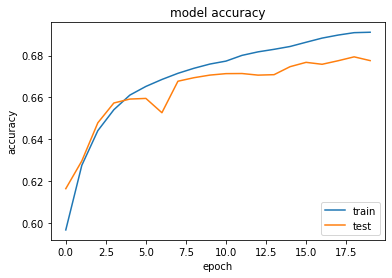

In [15]:
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Plot loss behavior during epochs. 

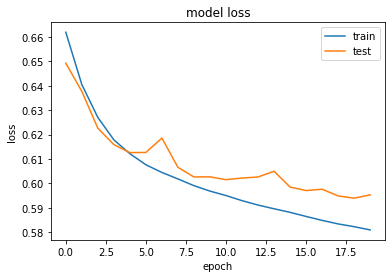

In [16]:
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()